In [1]:
# Project 3 
# model comparison section on R learn thing help for knn train and test

In [41]:
library("tidyverse")
library("DT")
library("ggplot2")
library("dplyr")
library(cluster)
library(pheatmap)
library(tigris)
library(sf)
library(geojsonio)
library(corrplot)
library("ggrepel")
library("ggcorrplot")
library(factoextra )

In [42]:
snapshot_urlfile = "https://raw.githubusercontent.com/ncliu95/smu_dm_project_2/main/texas_snapshot_with_census_pol.csv"

In [43]:
snapshot_cases <- read_csv(url(snapshot_urlfile))
snapshot_cases <- snapshot_cases %>% mutate_if(is.character, factor)

Rows: 254 Columns: 270
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (9): county_name.x, state.x, state.y, state_po, county_name.y, office...
dbl  (250): county_fips_code, state_fips_code, confirmed_cases, deaths, geo_...
lgl   (10): pop_5_years_over, speak_only_english_at_home, speak_spanish_at_h...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [44]:
# Calculate rates (per 1000 people) and select important variables
# And normalize by population
snapshot_cases <- snapshot_cases %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases,
    hispanic_ratio = hispanic_pop/total_pop,
    percent_male_pop = male_pop/total_pop,
    percent_female_pop = female_pop/total_pop,
    white_ratio = white_pop/total_pop,
    black_ratio = black_pop/total_pop,
    asian_ratio = asian_pop/total_pop,
    amerindian_ratio = amerindian_pop/total_pop,
    other_race_ratio = other_race_pop/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_employed_agriculture_forestry_fishing_hunting_mining = employed_agriculture_forestry_fishing_hunting_mining/total_pop,
    percent_employed_arts_entertainment_recreation_accommodation_food = employed_arts_entertainment_recreation_accommodation_food/total_pop,
    percent_employed_construction = employed_construction/total_pop,
    percent_employed_education_health_social = employed_education_health_social/total_pop,
    percent_employed_finance_insurance_real_estate = employed_finance_insurance_real_estate/total_pop,
    percent_employed_information = employed_information/total_pop,
    percent_employed_manufacturing = employed_manufacturing/total_pop,
    percent_employed_other_services_not_public_admin = employed_other_services_not_public_admin/total_pop,
    percent_employed_public_administration = employed_public_administration/total_pop,
    percent_employed_retail_trade = employed_retail_trade/total_pop,
    percent_employed_science_management_admin_waste = employed_science_management_admin_waste/total_pop,
    percent_employed_transportation_warehousing_utilities = employed_transportation_warehousing_utilities/total_pop,
    percent_employed_wholesale_trade = employed_wholesale_trade/total_pop,
    percent_unemployed = unemployed_pop/total_pop,
    percent_children = children/total_pop,
    percent_commute_by_bus = commuters_by_bus/employed_pop,
    percent_commute_by_car_truck_van = commuters_by_car_truck_van/employed_pop,
    percent_commute_by_carpool = commuters_by_carpool/employed_pop,
    percent_commute_by_subway = commuters_by_subway_or_elevated/employed_pop,
    percent_commute_by_driving_alone = commuters_drove_alone/employed_pop,
    percent_wfh = worked_at_home/employed_pop
)


In [45]:
# Download county data for Texas
tx_counties <- counties(state = "TX")
tx_counties$GEOID <- as.numeric(tx_counties$GEOID)
snapshot_cases <- left_join(snapshot_cases, tx_counties[, c("GEOID", "ALAND")], by = c("county_fips_code" = "GEOID"))
snapshot_cases <- snapshot_cases %>% mutate(
  pop_density = total_pop/ALAND)

Retrieving data for the year 2021



In [46]:
data <- select(snapshot_cases, 
                  'county_name.x',
'median_income',
'cases_per_1000',
'deaths_per_1000',
'death_per_case',
'hispanic_ratio',
'pop_density',
'party',
'median_age',
'poverty',
'bachelors_degree',   
'commuters_by_public_transportation',
'percent_male_pop',
'percent_female_pop',
'median_age',
'median_rent',
'white_ratio',
'black_ratio',
'asian_ratio',
'amerindian_ratio',
'other_race_ratio',
'percent_employed_agriculture_forestry_fishing_hunting_mining',
'percent_employed_arts_entertainment_recreation_accommodation_food', 
'percent_employed_construction' ,
'percent_employed_education_health_social',
'percent_employed_finance_insurance_real_estate',
'percent_employed_information', 
'percent_employed_manufacturing', 
'percent_employed_other_services_not_public_admin',
'percent_employed_public_administration',
'percent_employed_retail_trade',
'percent_employed_science_management_admin_waste',
'percent_employed_transportation_warehousing_utilities',
'percent_employed_wholesale_trade',
'percent_unemployed',
'percent_children',
 'percent_commute_by_bus',
'percent_commute_by_car_truck_van',
'percent_commute_by_carpool',
'percent_commute_by_subway',
'percent_commute_by_driving_alone',
'percent_wfh'             )

In [47]:
data <- data %>% mutate(party = ifelse(party == "REPUBLICAN", 0, 1))

In [48]:
# Check for missing values and if return true then nothing missing

table(complete.cases(data))


TRUE 
 254 

In [49]:
# Check that class variable is a factor! 
str(data)

tibble [254 × 41] (S3: tbl_df/tbl/data.frame)
 $ county_name.x                                                    : Factor w/ 254 levels "Anderson County",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ median_income                                                    : num [1:254] 42313 70753 46472 44601 63192 ...
 $ cases_per_1000                                                   : num [1:254] 96.5 91.4 77.1 36 78.9 ...
 $ deaths_per_1000                                                  : num [1:254] 1.3 2.11 2.2 1.05 1.14 ...
 $ death_per_case                                                   : num [1:254] 0.0135 0.023 0.0285 0.0291 0.0144 ...
 $ hispanic_ratio                                                   : num [1:254] 0.1728 0.554 0.2152 0.2704 0.0831 ...
 $ pop_density                                                      : num [1:254] 2.10e-05 4.52e-06 4.24e-05 3.80e-05 3.76e-06 ...
 $ party                                                            : num [1:254] 0 0 0 0 0 0 0 0 0 0 ...
 $ me

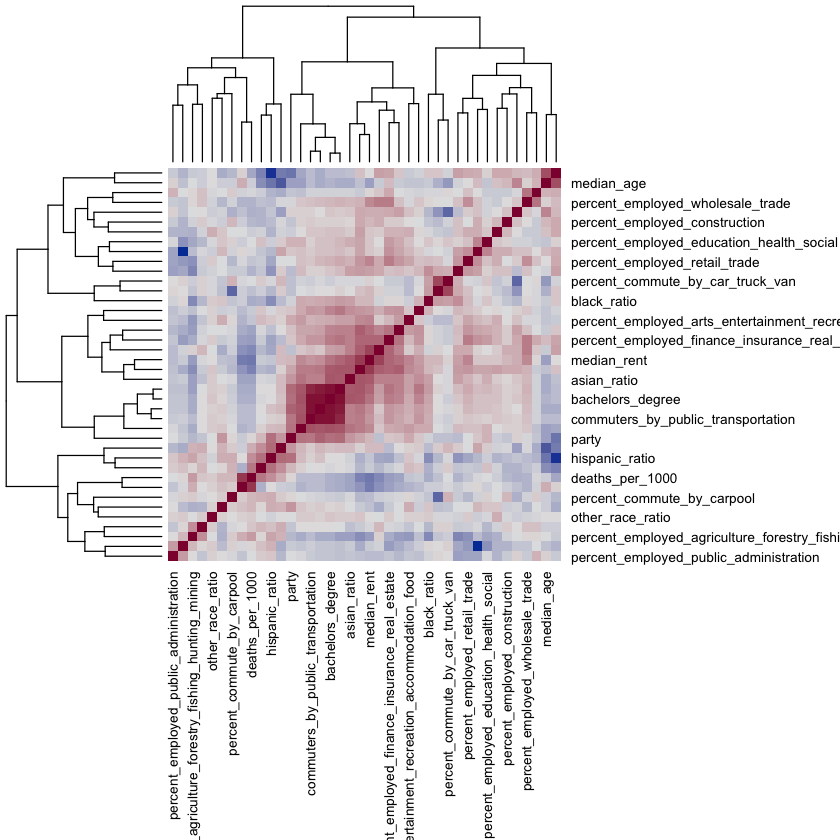

In [50]:
# Check correlation for numeric variables 

library('seriation')
cm <- cor(data %>% select_if(is.numeric) %>% na.omit)
hmap(cm, margins = c(14,14))

In [51]:
# Create class variable 
# Bad is the considered a high fatality rate, 0.024 is taken from project 2 average deaths per case value
data <- data %>% mutate(bad = as.factor(death_per_case >= 0.024))

In [52]:
data %>% pull(bad) %>% table()

.
FALSE  TRUE 
  142   112 

In [53]:
# This helps us to label which counties in Texas are considered bad which therefore tells us who needs the most help
data %>% group_by(county_name.x) %>% 
    summarize(bad_pct = sum(bad == TRUE)/n()) %>%
    arrange(desc(bad_pct))

county_name.x,bad_pct
<fct>,<dbl>
Angelina County,1
Aransas County,1
Armstrong County,1
Bandera County,1
Baylor County,1
Blanco County,1
Bowie County,1
Briscoe County,1
Brooks County,1


In [67]:
# Split into training data
set.seed(12345)
split_length <- length(data) / 2
cases_train <- sample_n(data,split_length)
cases_train %>% pull(bad) %>% table()

.
FALSE  TRUE 
   13     8 

In [68]:
# Split into the test data
cases_test <- data %>% filter(!(county_name.x %in% cases_train))
cases_test %>% pull(bad) %>% table() 

.
FALSE  TRUE 
  142   112 